In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.utils import class_weight
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from scipy.stats.mstats import winsorize

In [2]:
train = pd.read_csv("data_set/train_u6lujuX_CVtuZ9i.csv")
test = pd.read_csv("data_set/test_Y3wMUE5_7gLdaTN.csv")


final_id = test['Loan_ID'] # For final prediction

## Identify imbalanced dataset

<class 'pandas.core.frame.DataFrame'>
Class 0: 422
Class 1: 192
Proportion: 2.2 : 1


<AxesSubplot:title={'center':'Count (loan_paid)'}>

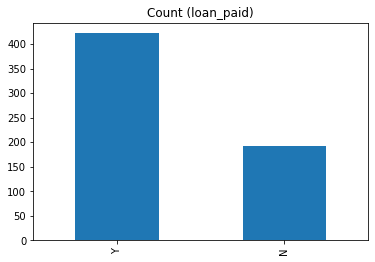

In [3]:
print(type(train))

target_count = train.Loan_Status.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (loan_paid)')

## Data Cleaning: Handle missing values and outliers

In [4]:
def separator(data):
    
    #Seperate the columns based on the type (object or numeric)
    loan_object = [] #object type
    loan_numeric = [] #numeric type

    for col_name in data.columns:
        if data [col_name].dtype == 'object':
            loan_object.append(col_name)
        
        if data [col_name].dtype == 'int64' or data [col_name].dtype == 'float64':
            loan_numeric.append(col_name)
    
    return data [loan_object], data [loan_numeric]


train_object_cols, train_num_cols = separator(train)
test_object_cols, test_num_cols = separator(test)
    

print(train_object_cols.dtypes)
print('-'*10, '\n')
print(train_num_cols.dtypes)

Loan_ID          object
Gender           object
Married          object
Dependents       object
Education        object
Self_Employed    object
Property_Area    object
Loan_Status      object
dtype: object
---------- 

ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
dtype: object


## Preprocessing for Numerical Columns

In [5]:
print(train_num_cols.isna().sum())
print('-'*10, '\n')
print(test_num_cols.isna().sum())

ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
dtype: int64
---------- 

ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
dtype: int64


## Distribution of traning set

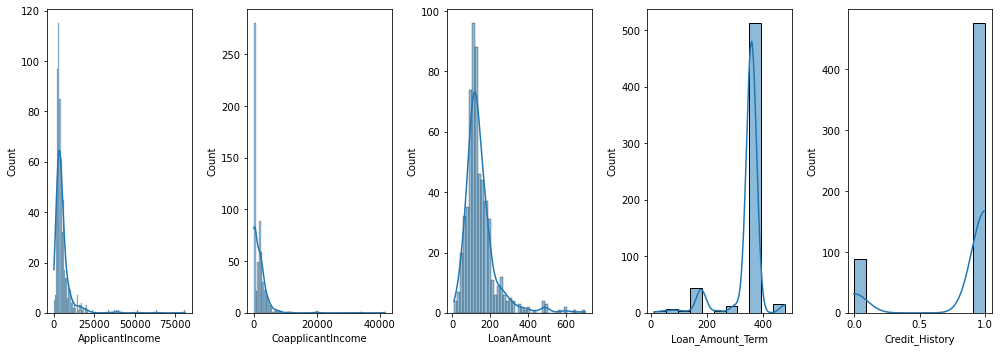

In [6]:
# Define the columns
columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

# Create a figure with a 4x3 grid
fig, axs = plt.subplots(1, 5, figsize=(14, 5))

# Flatten the grid axes for easy iteration
axs = axs.flatten()

# Iterate over the columns and plot the distribution
for i, column in enumerate(columns):
    ax = axs[i]
    sns.histplot(train_num_cols[column], ax=ax, kde=True)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()     

## Distribution of Test Set

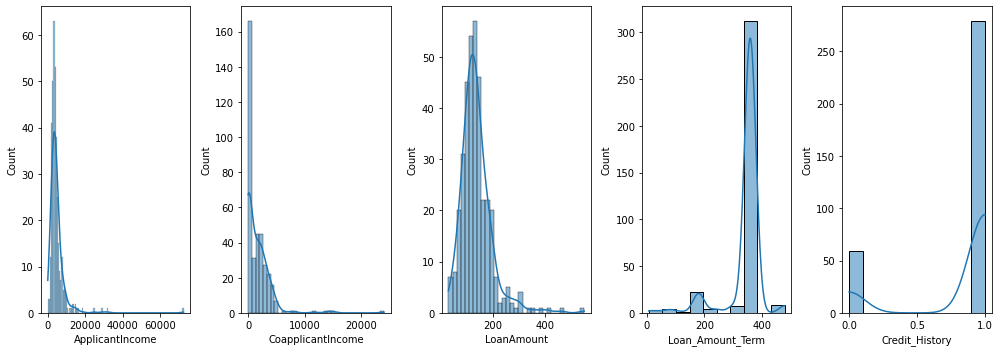

In [7]:
## Distribution of Test Set# Define the columns
columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

# Create a figure with a 4x3 grid
fig, axs = plt.subplots(1, 5, figsize=(14, 5))

# Flatten the grid axes for easy iteration
axs = axs.flatten()

# Iterate over the columns and plot the distribution
for i, column in enumerate(columns):
    ax = axs[i]
    sns.histplot(test_num_cols[column], ax=ax, kde=True)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()     

Let's try to visualize the distribution of the numerical columns with the condition of Loan_Status = Y / Loan_Status = N

In [8]:
train_num_cols_backup = train_num_cols.copy()
train_num_cols_backup['Loan_Status'] = train_object_cols['Loan_Status']

In [9]:
Loan_Y = train_num_cols_backup[train_num_cols_backup['Loan_Status'] == 'Y']
Loan_N = train_num_cols_backup[train_num_cols_backup['Loan_Status'] == 'N']

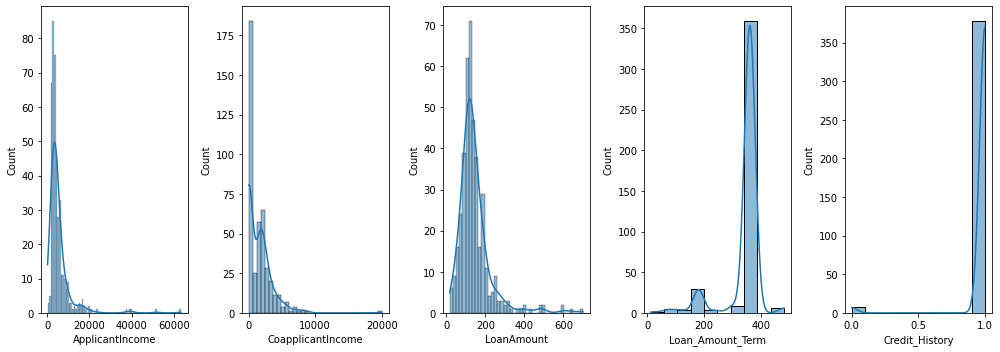

In [10]:
## Distribution of Test Set# Define the columns
columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

# Create a figure with a 4x3 grid
fig, axs = plt.subplots(1, 5, figsize=(14, 5))

# Flatten the grid axes for easy iteration
axs = axs.flatten()

# Iterate over the columns and plot the distribution
for i, column in enumerate(columns):
    ax = axs[i]
    sns.histplot(Loan_Y[column], ax=ax, kde=True)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()     

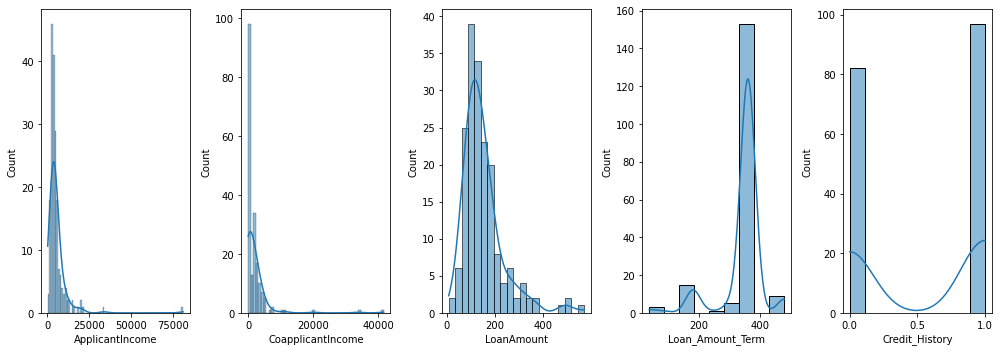

In [11]:
## Distribution of Test Set# Define the columns
columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']

# Create a figure with a 4x3 grid
fig, axs = plt.subplots(1, 5, figsize=(14, 5))

# Flatten the grid axes for easy iteration
axs = axs.flatten()

# Iterate over the columns and plot the distribution
for i, column in enumerate(columns):
    ax = axs[i]
    sns.histplot(Loan_N[column], ax=ax, kde=True)
    ax.set_xlabel(column)
    ax.set_ylabel('Count')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()     

We can obeserve the differences in the distribution for the target variable especially in the "Credit_History".

## Impute Na Values

In [12]:
test_num_cols_v2 = test_num_cols.copy()

In [13]:
print(train_num_cols.isna().sum())
print('-'*10, '\n')
print(test_num_cols_v2.isna().sum())

ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
dtype: int64
---------- 

ApplicantIncome       0
CoapplicantIncome     0
LoanAmount            5
Loan_Amount_Term      6
Credit_History       29
dtype: int64


In [14]:
## Test dataset

# Skewed distribution, median is more of an appropriate value to impute the nan,
test_num_cols_v2['LoanAmount'] = test_num_cols['LoanAmount'].fillna(test_num_cols['LoanAmount'].median())
test_num_cols_v2['Loan_Amount_Term'] = test_num_cols['Loan_Amount_Term'].fillna(test_num_cols['Loan_Amount_Term'].median())
test_num_cols_v2['Credit_History'] = test_num_cols['Credit_History'].fillna(test_num_cols['Loan_Amount_Term'].median())

In [15]:
Loan_Y['LoanAmount'] = Loan_Y['LoanAmount'].fillna(Loan_Y['LoanAmount'].median())
Loan_Y['Loan_Amount_Term'] = Loan_Y['Loan_Amount_Term'].fillna(Loan_Y['Loan_Amount_Term'].median())
Loan_Y['Credit_History'] = Loan_Y['Credit_History'].fillna(Loan_Y['Loan_Amount_Term'].median())

Loan_N['LoanAmount'] = Loan_N['LoanAmount'].fillna(Loan_N['LoanAmount'].median())
Loan_N['Loan_Amount_Term'] = Loan_N['Loan_Amount_Term'].fillna(Loan_N['Loan_Amount_Term'].median())
Loan_N['Credit_History'] = Loan_N['Credit_History'].fillna(Loan_N['Loan_Amount_Term'].median())

C:\Users\hp\AppData\Local\Temp\ipykernel_23304\4121114817.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Loan_Y['LoanAmount'] = Loan_Y['LoanAmount'].fillna(Loan_Y['LoanAmount'].median())
C:\Users\hp\AppData\Local\Temp\ipykernel_23304\4121114817.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Loan_Y['Loan_Amount_Term'] = Loan_Y['Loan_Amount_Term'].fillna(Loan_Y['Loan_Amount_Term'].median())
C:\Users\hp\AppData\Local\Temp\ipykernel_23304\4121114817.py:3: SettingWithCopyWarning: 
A value is trying to 

In [16]:
# Concatanate the new training set based on the value of "Loan_Status"

train_num_cols_v2 = pd.concat([Loan_Y, Loan_N], axis=0)

## Preprocessing for object columns

In [17]:
print(train_object_cols.isna().sum())
print('-'*10, '\n')
print(test_object_cols.isna().sum())

Loan_ID           0
Gender           13
Married           3
Dependents       15
Education         0
Self_Employed    32
Property_Area     0
Loan_Status       0
dtype: int64
---------- 

Loan_ID           0
Gender           11
Married           0
Dependents       10
Education         0
Self_Employed    23
Property_Area     0
dtype: int64


## Simple Visualization

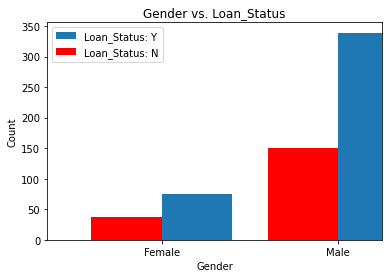

In [18]:
# Group by Gender and Loan_Status and count the occurrences
gender_loan_status_counts = train_object_cols.groupby(['Gender', 'Loan_Status']).size().unstack()

# Create separate vertical bar plots for each Loan_Status
fig, ax = plt.subplots()
gender_loan_status_counts['Y'].plot(kind='bar', position=0, width=0.4, ax=ax, label='Loan_Status: Y')
gender_loan_status_counts['N'].plot(kind='bar', position=1, width=0.4, ax=ax, label='Loan_Status: N', color="red")

plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender vs. Loan_Status')

# Adjust the angle of the x-axis labels to be horizontal
plt.setp(ax.get_xticklabels(), rotation=0)

plt.legend()
plt.show()

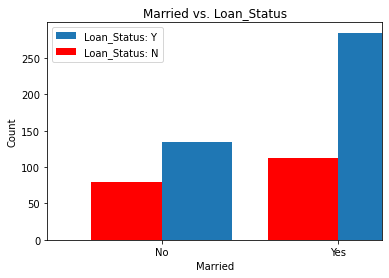

In [19]:
# Group by Gender and Loan_Status and count the occurrences
gender_loan_status_counts = train_object_cols.groupby(['Married', 'Loan_Status']).size().unstack()

# Create separate vertical bar plots for each Loan_Status
fig, ax = plt.subplots()
gender_loan_status_counts['Y'].plot(kind='bar', position=0, width=0.4, ax=ax, label='Loan_Status: Y')
gender_loan_status_counts['N'].plot(kind='bar', position=1, width=0.4, ax=ax, label='Loan_Status: N', color="red")

plt.xlabel('Married')
plt.ylabel('Count')
plt.title('Married vs. Loan_Status')

# Adjust the angle of the x-axis labels to be horizontal
plt.setp(ax.get_xticklabels(), rotation=0)

plt.legend()
plt.show()

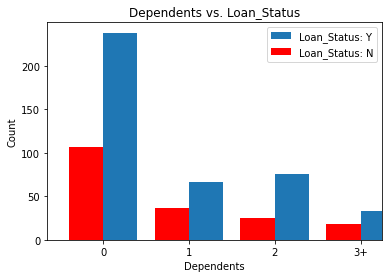

In [20]:
# Group by Gender and Loan_Status and count the occurrences
gender_loan_status_counts = train_object_cols.groupby(['Dependents', 'Loan_Status']).size().unstack()

# Create separate vertical bar plots for each Loan_Status
fig, ax = plt.subplots()
gender_loan_status_counts['Y'].plot(kind='bar', position=0, width=0.4, ax=ax, label='Loan_Status: Y')
gender_loan_status_counts['N'].plot(kind='bar', position=1, width=0.4, ax=ax, label='Loan_Status: N', color="red")

plt.xlabel('Dependents')
plt.ylabel('Count')
plt.title('Dependents vs. Loan_Status')

# Adjust the angle of the x-axis labels to be horizontal
plt.setp(ax.get_xticklabels(), rotation=0)

plt.legend()
plt.show()

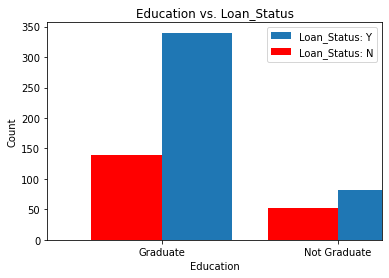

In [21]:
# Group by Gender and Loan_Status and count the occurrences
gender_loan_status_counts = train_object_cols.groupby(['Education', 'Loan_Status']).size().unstack()

# Create separate vertical bar plots for each Loan_Status
fig, ax = plt.subplots()
gender_loan_status_counts['Y'].plot(kind='bar', position=0, width=0.4, ax=ax, label='Loan_Status: Y')
gender_loan_status_counts['N'].plot(kind='bar', position=1, width=0.4, ax=ax, label='Loan_Status: N', color="red")

plt.xlabel('Education')
plt.ylabel('Count')
plt.title('Education vs. Loan_Status')

# Adjust the angle of the x-axis labels to be horizontal
plt.setp(ax.get_xticklabels(), rotation=0)

plt.legend()
plt.show()

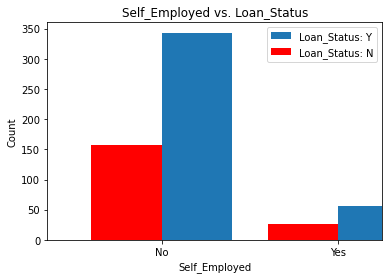

In [22]:
# Group by Gender and Loan_Status and count the occurrences
gender_loan_status_counts = train_object_cols.groupby(['Self_Employed', 'Loan_Status']).size().unstack()

# Create separate vertical bar plots for each Loan_Status
fig, ax = plt.subplots()
gender_loan_status_counts['Y'].plot(kind='bar', position=0, width=0.4, ax=ax, label='Loan_Status: Y')
gender_loan_status_counts['N'].plot(kind='bar', position=1, width=0.4, ax=ax, label='Loan_Status: N', color="red")

plt.xlabel('Self_Employed')
plt.ylabel('Count')
plt.title('Self_Employed vs. Loan_Status')

# Adjust the angle of the x-axis labels to be horizontal
plt.setp(ax.get_xticklabels(), rotation=0)

plt.legend()
plt.show()

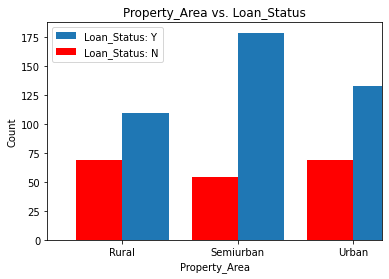

In [23]:
# Group by Gender and Loan_Status and count the occurrences
gender_loan_status_counts = train_object_cols.groupby(['Property_Area', 'Loan_Status']).size().unstack()

# Create separate vertical bar plots for each Loan_Status
fig, ax = plt.subplots()
gender_loan_status_counts['Y'].plot(kind='bar', position=0, width=0.4, ax=ax, label='Loan_Status: Y')
gender_loan_status_counts['N'].plot(kind='bar', position=1, width=0.4, ax=ax, label='Loan_Status: N', color="red")

plt.xlabel('Property_Area')
plt.ylabel('Count')
plt.title('Property_Area vs. Loan_Status')

# Adjust the angle of the x-axis labels to be horizontal
plt.setp(ax.get_xticklabels(), rotation=0)

plt.legend()
plt.show()

In [24]:

train_object_cols_v2 = train_object_cols.drop(['Loan_ID'], axis=1)
test_object_cols_v2 = test_object_cols.drop(['Loan_ID'], axis=1)

In [25]:
train_object_cols_v2 ['Gender'] = train_object_cols['Gender'].fillna(train_object_cols['Gender'].mode().iloc[0])
train_object_cols_v2 ['Married'] = train_object_cols['Married'].fillna(train_object_cols['Married'].mode().iloc[0])
train_object_cols_v2 ['Dependents'] = train_object_cols['Dependents'].fillna(train_object_cols['Dependents'].mode().iloc[0])
train_object_cols_v2 ['Self_Employed'] = train_object_cols['Self_Employed'].fillna(train_object_cols['Self_Employed'].mode().iloc[0])

In [26]:
test_object_cols_v2 ['Gender'] = test_object_cols['Gender'].fillna(test_object_cols['Gender'].mode().iloc[0])
test_object_cols_v2 ['Married'] = test_object_cols['Married'].fillna(test_object_cols['Married'].mode().iloc[0])
test_object_cols_v2 ['Dependents'] = test_object_cols['Dependents'].fillna(test_object_cols['Dependents'].mode().iloc[0])
test_object_cols_v2 ['Self_Employed'] = test_object_cols['Self_Employed'].fillna(test_object_cols['Self_Employed'].mode().iloc[0])

In [27]:
print(train_object_cols_v2.isna().sum())
print('-'*10, '\n')
print(test_object_cols_v2.isna().sum())

Gender           0
Married          0
Dependents       0
Education        0
Self_Employed    0
Property_Area    0
Loan_Status      0
dtype: int64
---------- 

Gender           0
Married          0
Dependents       0
Education        0
Self_Employed    0
Property_Area    0
dtype: int64


## Combine data

In [28]:
train_num_cols_v3 = train_num_cols_v2.drop(["Loan_Status"],  axis=1).copy()

In [29]:
cleaned_train = pd.concat([train_num_cols_v3, train_object_cols_v2], axis=1)
cleaned_test = pd.concat([test_num_cols_v2, test_object_cols_v2], axis=1)

In [30]:
print(cleaned_train.columns)

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Gender', 'Married', 'Dependents',
       'Education', 'Self_Employed', 'Property_Area', 'Loan_Status'],
      dtype='object')


In [31]:
print(cleaned_test.columns)

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Gender', 'Married', 'Dependents',
       'Education', 'Self_Employed', 'Property_Area'],
      dtype='object')


In [32]:
X = cleaned_train.drop(["Loan_Status"],  axis=1).copy()
y = cleaned_train["Loan_Status"].copy()

## Visualize outliers

In [33]:
def visualize_outliers_boxplot(df, column):
    """
    Visualizes outliers in a column using a box plot.
    
    Args:
        df (pandas.DataFrame): The dataframe containing the data.
        column (str): The column name to visualize outliers.
    """
    plt.figure(figsize=(8, 6))
    plt.boxplot(df[column])
    plt.title('Box Plot - {}'.format(column))
    plt.xlabel('Column')
    plt.ylabel('Values')
    plt.show()
    
    q1 = df[column].quantile(0.25)  
    q3 = df[column].quantile(0.75)  
    iqr = q3 - q1  
    lower_bound = q1 - 1.5 * iqr  # Lower bound for outlier removal
    upper_bound = q3 + 1.5 * iqr  # Upper bound for outlier removal
    
    num_outliers = ((df[column] < lower_bound) | (df[column] > upper_bound)).sum()
    
    print("Number of outliers in '{}': {}".format(column, num_outliers))

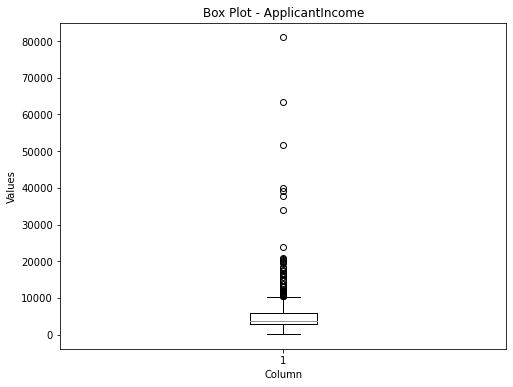

Number of outliers in 'ApplicantIncome': 50


In [34]:
visualize_outliers_boxplot(X, "ApplicantIncome")

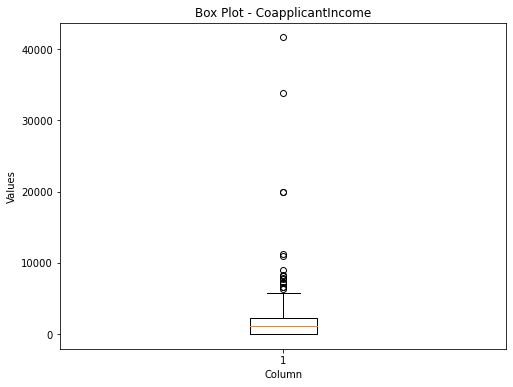

Number of outliers in 'CoapplicantIncome': 18


In [35]:
visualize_outliers_boxplot(X, "CoapplicantIncome")

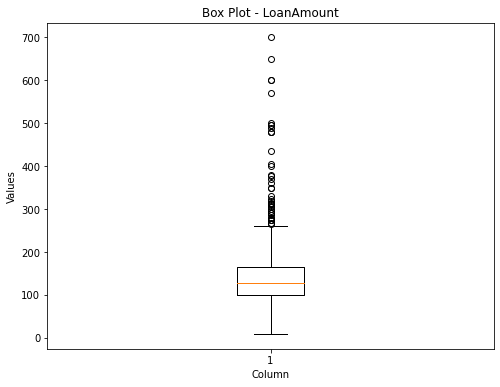

Number of outliers in 'LoanAmount': 41


In [36]:
visualize_outliers_boxplot(X, "LoanAmount")

In [37]:
new_df = pd.concat([X, y], axis=1)

## Remove outliers

In [38]:
def remove_outliers_iqr(df, columns):
    """
    Removes outliers from specified columns in a dataframe using the interquartile range (IQR) method.
    
    Args:
        df (pandas.DataFrame): The dataframe containing the data.
        columns (list): A list of column names to consider for outlier removal.
    
    Returns:
        pandas.DataFrame: The dataframe with outliers removed.
    """
    print("Shape before outlier removal:", df.shape)  # Print shape before removal
    df_cleaned = df.copy()  # Create a copy of the original dataframe
    
    for column in columns:
        q1 = df_cleaned[column].quantile(0.25)  # First quartile
        q3 = df_cleaned[column].quantile(0.75)  # Third quartile
        iqr = q3 - q1  # Interquartile range
        lower_bound = q1 - 1.5 * iqr  # Lower bound for outlier removal
        upper_bound = q3 + 1.5 * iqr  # Upper bound for outlier removal
        
        # Remove outliers outside the lower and upper bounds
        df_cleaned = df_cleaned[(df_cleaned[column] >= lower_bound) & (df_cleaned[column] <= upper_bound)]
    
    print("Shape after outlier removal:", df_cleaned.shape)  # Print shape after removal
    return df_cleaned


In [39]:
new_removed_outliers = remove_outliers_iqr(new_df, ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount'])

Shape before outlier removal: (614, 12)
Shape after outlier removal: (520, 12)


In [40]:
print(new_removed_outliers.columns)

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Gender', 'Married', 'Dependents',
       'Education', 'Self_Employed', 'Property_Area', 'Loan_Status'],
      dtype='object')


<class 'pandas.core.frame.DataFrame'>
Class 0: 362
Class 1: 158
Proportion: 2.29 : 1


<AxesSubplot:title={'center':'Count (loan_paid)'}>

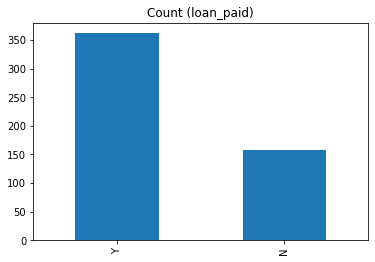

In [41]:
print(type(new_removed_outliers))

target_count = new_removed_outliers.Loan_Status.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (loan_paid)')

In [42]:
X_v2 = new_removed_outliers.drop(["Loan_Status"],  axis=1).copy()
y_v2 = new_removed_outliers["Loan_Status"].copy()

In [43]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, f1_score, recall_score, accuracy_score

In [44]:
#test_size=0.2 means that 20% of the data will be used for testing and 80% of the data will be used for training. This is a common split size used in machine learning, 

X_train, X_test, y_train, y_test = train_test_split(X_v2, y_v2, test_size=0.2, random_state=21)

# Identify the categorical columns
cat_cols = X.select_dtypes(include='object').columns

# Create a one-hot encoder object
encoder = OneHotEncoder(handle_unknown='ignore')

# Create a column transformer object
ct = ColumnTransformer([('one_hot', encoder, cat_cols)], remainder='passthrough')

# Fit the column transformer on the training data
ct.fit(X_train)

# Transform the training and test data
X_train_encoded = ct.transform(X_train)
X_test_encoded = ct.transform(X_test)
y_train = y_train.values
y_test = y_test.values

In [45]:
# Retrieve the columns name after applying one-hot encoding

column_names = ct.get_feature_names_out()

# Create DataFrame for X_train_encoded and  X_test_encoded 
X_train_df = pd.DataFrame(X_train_encoded, columns=column_names)
X_test_df = pd.DataFrame(X_test_encoded, columns=column_names)

In [46]:
X_train_df_v2 = X_train_df.copy()
X_test_df_v2 = X_test_df.copy()

## SMOTE oversampling

In [47]:
from imblearn.over_sampling import SMOTE

# Assuming you have your feature matrix X and target variable y

# Instantiate SMOTE
smote = SMOTE()

# Apply SMOTE oversampling
X_resampled, y_resampled = smote.fit_resample(X_train_df_v2, y_train)

# Check the class distribution after oversampling
print("Before SMOTE:")
print(y_train.shape)
print("After SMOTE:")
print(y_resampled.shape)

Before SMOTE:
(416,)
After SMOTE:
(574,)


In [48]:
print(X_resampled.shape)

(574, 20)


## Apply log transformation to columns with continuous variables

In [49]:

columns_to_log = ['remainder__ApplicantIncome', 'remainder__CoapplicantIncome', 
                  'remainder__LoanAmount', 'remainder__Loan_Amount_Term']


for col in columns_to_log:
    X_resampled[col]  = np.log1p(X_resampled[col])
    X_test_df_v2[col] = np.log1p(X_test_df_v2[col])


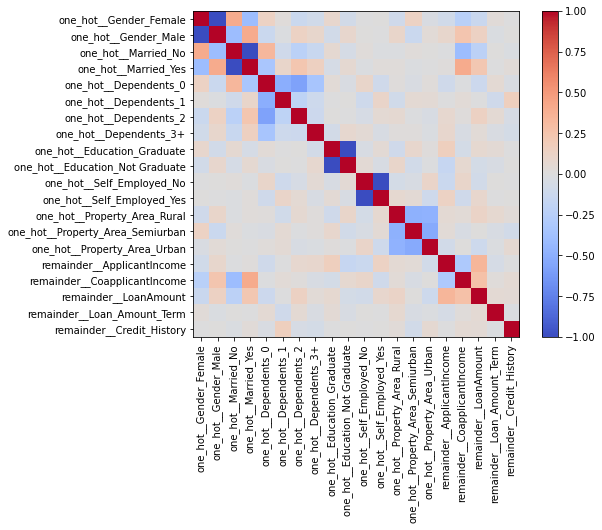

In [50]:
corr_matrix = X_resampled.corr()

# visualize correlation matrix as a heatmap
fig = plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.show()

In [51]:
for var1 in corr_matrix.columns:
    for var2 in corr_matrix.columns:
        if (corr_matrix.loc[var1,var2] >= -1.1) and (corr_matrix.loc[var1,var2] <= -0.8) and (var1 != var2):
            print(f"{var1} and {var2} have a correlation score of {corr_matrix.loc[var1,var2]}")

one_hot__Gender_Female and one_hot__Gender_Male have a correlation score of -1.0
one_hot__Gender_Male and one_hot__Gender_Female have a correlation score of -1.0
one_hot__Married_No and one_hot__Married_Yes have a correlation score of -0.9999999999999997
one_hot__Married_Yes and one_hot__Married_No have a correlation score of -0.9999999999999997
one_hot__Education_Graduate and one_hot__Education_Not Graduate have a correlation score of -0.9999999999999997
one_hot__Education_Not Graduate and one_hot__Education_Graduate have a correlation score of -0.9999999999999997
one_hot__Self_Employed_No and one_hot__Self_Employed_Yes have a correlation score of -1.0
one_hot__Self_Employed_Yes and one_hot__Self_Employed_No have a correlation score of -1.0


In [52]:
X_resampled_v2 = X_resampled.drop(['one_hot__Gender_Female', 'one_hot__Married_No', 'one_hot__Education_Graduate', 'one_hot__Self_Employed_No'], axis=1)
X_test_df_v3 = X_test_df_v2.drop(['one_hot__Gender_Female', 'one_hot__Married_No', 'one_hot__Education_Graduate', 'one_hot__Self_Employed_No'], axis=1)

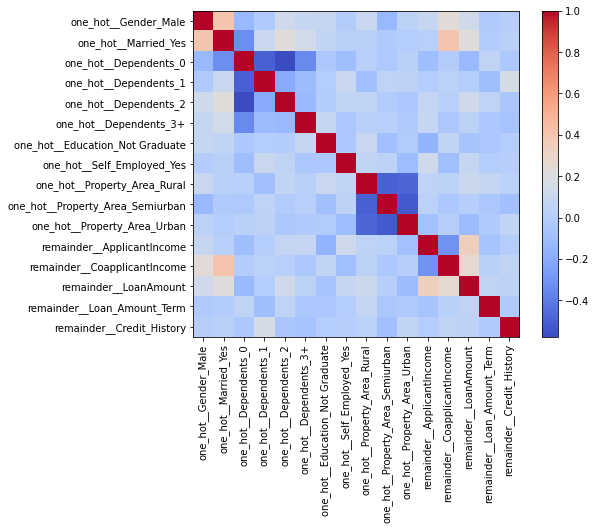

In [53]:
corr_matrix = X_resampled_v2.corr()

# visualize correlation matrix as a heatmap
fig = plt.figure(figsize=(8, 6))
plt.imshow(corr_matrix, cmap='coolwarm', interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(corr_matrix)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix)), corr_matrix.columns)
plt.show()

In [54]:
X_train_encoded = X_resampled_v2.values
X_test_encoded = X_test_df_v3.values

In [55]:
from sklearn.preprocessing import RobustScaler

In [56]:
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train_encoded)
X_test_scaled = scaler.transform(X_test_encoded)

In [57]:
y_train = y_resampled.copy()

## Simple Modeling

Cross validate models

I compared 11 popular classifiers and evaluate the accuracy, precision, recall and f1-score of each classifier by a stratified kfold cross validation procedure.

- Decision Tree
- AdaBoost
- Random Forest
- Extra Trees
- Gradient Boosting
- SVC
- Multiple layer perceprton (neural network)
- KNN
- Logistic regression
- Linear Discriminant Analysis
- Quadratic Discriminant Analysis (QDA)

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import ExtraTreesClassifier

In [59]:
# Cross validate model with Kfold stratified cross val
kfold = StratifiedKFold(n_splits=5)

In [60]:
random_state = 42
classifiers = []

classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())
classifiers.append(QuadraticDiscriminantAnalysis())

In [61]:
cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train_scaled, y = y_train, scoring = "accuracy", cv = kfold, n_jobs=4))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())

c:\Users\hp\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


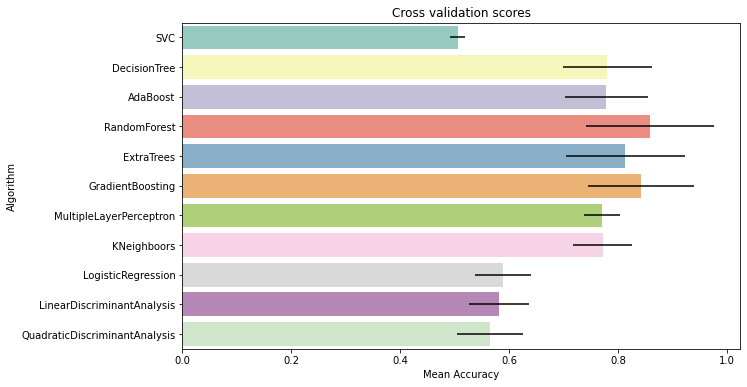

In [62]:
# Create the DataFrame with cross-validation results
cv_res = pd.DataFrame({
    "CrossValMeans": cv_means,
    "CrossValErrors": cv_std,
    "Algorithm": [
        "SVC", "DecisionTree", "AdaBoost", "RandomForest", "ExtraTrees", "GradientBoosting",
        "MultipleLayerPerceptron", "KNeighboors", "LogisticRegression",
        "LinearDiscriminantAnalysis", "QuadraticDiscriminantAnalysis"
    ]
})

# Set the figure size before creating the bar plot
plt.figure(figsize=(10, 6))

# Create the bar plot
g = sns.barplot(
    "CrossValMeans", "Algorithm", data=cv_res, palette="Set3", orient="h", **{'xerr': cv_std}
)
g.set_xlabel("Mean Accuracy")
g = g.set_title("Cross validation scores")

# Show the plot
plt.show()

I decided to use Decision Tree, Random Forest, Extra Trees, Gradient Boosting and Multiple Layer Perceptron  for ensemble modeling.

## AdaBoost

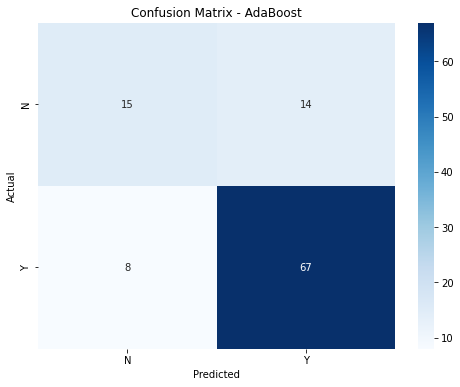

In [63]:
dt = DecisionTreeClassifier()

model = AdaBoostClassifier(dt)

# Define the parameter grid
adaboost_param_grid = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.1, 0.5, 1.0],
    "base_estimator__max_depth": [1, 2, 3]
}

# Perform grid search using cross-validation
grid_search = GridSearchCV(model, param_grid=adaboost_param_grid, cv=kfold, scoring="accuracy", n_jobs=4)
grid_search.fit(X_train_scaled, y_train)

# Get the best model and its parameters
best_model_adaboost = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions using the best model
predictions_adaboost = best_model_adaboost.predict(X_test_scaled)

cm = confusion_matrix(y_test, predictions_adaboost)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'Y'], yticklabels=['N', 'Y'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - AdaBoost')
plt.show()

In [64]:
print(best_model_adaboost)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                   learning_rate=0.1)


In [65]:
# Compute precision, F1 score, and recall score
precision = precision_score(y_test, predictions_adaboost, pos_label='Y')
f1 = f1_score(y_test, predictions_adaboost, pos_label='Y')
recall = recall_score(y_test, predictions_adaboost, pos_label='Y')
acc = accuracy_score(y_test, predictions_adaboost)

# Print the scores
print("Precision: {:.2f}".format(precision))
print("Accuracy: {:.2f}".format(acc))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Precision: 0.83
Accuracy: 0.79
Recall: 0.89
F1 Score: 0.86


## Decision Tree

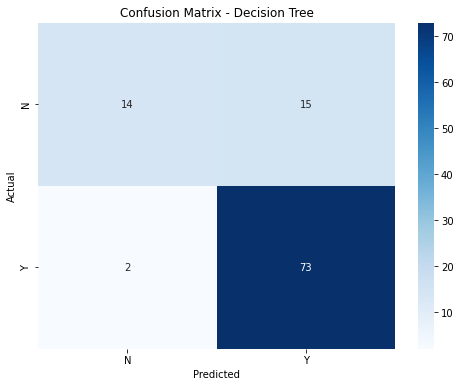

In [66]:
dt = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}


# Perform grid search using cross-validation
grid_search = GridSearchCV(dt, param_grid = param_grid, cv=kfold, scoring="accuracy", n_jobs= 4)
grid_search.fit(X_train_scaled, y_train)

# Get the best model and its parameters
best_model_dt = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions using the best model
predictions_dt = best_model_dt.predict(X_test_scaled)

cm = confusion_matrix(y_test, predictions_dt)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'Y'], yticklabels=['N', 'Y'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree')
plt.show()



In [67]:
print(best_model_dt)

DecisionTreeClassifier(max_depth=3, min_samples_leaf=4)


In [68]:
# Compute precision, F1 score, and recall score
precision = precision_score(y_test, predictions_dt, pos_label='Y')
f1 = f1_score(y_test, predictions_dt, pos_label='Y')
recall = recall_score(y_test, predictions_dt, pos_label='Y')
acc = accuracy_score(y_test, predictions_dt)

# Print the scores
print("Precision: {:.2f}".format(precision))
print("Accuracy: {:.2f}".format(acc))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Precision: 0.83
Accuracy: 0.84
Recall: 0.97
F1 Score: 0.90


## Extra Tree

c:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
1215 fits failed out of a total of 3645.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1215 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\hp\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "c:\Users\hp\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\Users\hp\anaconda3\lib\site-packages\joblib\para

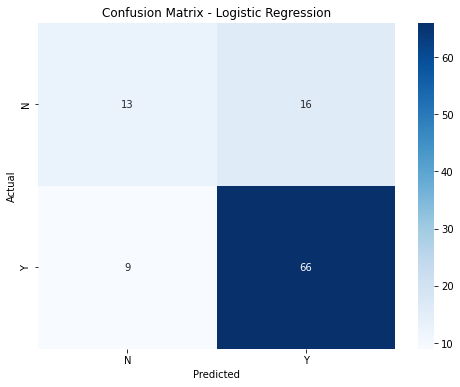

In [69]:
et = ExtraTreesClassifier()

param_grid = {"max_depth": [None, 1 ,5],
              "max_features": ["sqrt", "log2", None],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100, 200, 300],
              "criterion": ["gini", "entropy", "log_loss"]}


# Perform grid search using cross-validation
grid_search = GridSearchCV(et, param_grid = param_grid, cv=kfold, scoring="accuracy", n_jobs= 4)
grid_search.fit(X_train_scaled, y_train)


# Get the best model and its parameters
best_model_et = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions using the best model
predictions_et = best_model_et.predict(X_test_scaled)

cm = confusion_matrix(y_test, predictions_et)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'Y'], yticklabels=['N', 'Y'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [70]:
print(best_model_et)

ExtraTreesClassifier(criterion='entropy', max_features='sqrt',
                     min_samples_split=3, n_estimators=300)


In [71]:
# Compute precision, F1 score, and recall score
precision = precision_score(y_test, predictions_et, pos_label='Y')
f1 = f1_score(y_test, predictions_et, pos_label='Y')
recall = recall_score(y_test, predictions_et, pos_label='Y')
acc = accuracy_score(y_test, predictions_et)

# Print the scores
print("Precision: {:.2f}".format(precision))
print("Accuracy: {:.2f}".format(acc))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Precision: 0.80
Accuracy: 0.76
Recall: 0.88
F1 Score: 0.84


## Random Forest

c:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
1620 fits failed out of a total of 4860.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1620 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\hp\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\hp\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 450, in fit
    trees = Parallel(
  File "c:\Users\hp\anaconda3\lib\site-packages\joblib\parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "c:\Users\hp\anaconda3\lib\site-packages\joblib\para

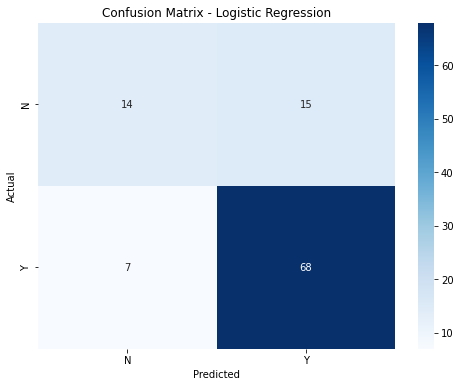

In [72]:
# Create a random forest model
model = RandomForestClassifier()

# Define the parameter grid
rf_param_grid = {"max_depth": [None, 5, 10, 15],
                 "max_features": ["sqrt", "log2", None],
               "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "n_estimators" :[100, 200 ,300],
              "criterion": ["gini", "entropy", "log_loss"]}


# Perform grid search using cross-validation
grid_search = GridSearchCV(model, param_grid = rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4)
grid_search.fit(X_train_scaled, y_train)

# Get the best model and its parameters
best_model_rf = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions using the best model
predictions_rf = best_model_rf.predict(X_test_scaled)

cm = confusion_matrix(y_test, predictions_rf)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'Y'], yticklabels=['N', 'Y'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [73]:
print(best_model_rf)

RandomForestClassifier(max_depth=10, max_features='log2', n_estimators=200)


In [74]:
# Compute precision, F1 score, and recall score
precision = precision_score(y_test, predictions_rf, pos_label='Y')
f1 = f1_score(y_test, predictions_rf, pos_label='Y')
recall = recall_score(y_test, predictions_rf, pos_label='Y')
acc = accuracy_score(y_test, predictions_rf)

# Print the scores
print("Precision: {:.2f}".format(precision))
print("Accuracy: {:.2f}".format(acc))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Precision: 0.82
Accuracy: 0.79
Recall: 0.91
F1 Score: 0.86


## Gradient Boosting

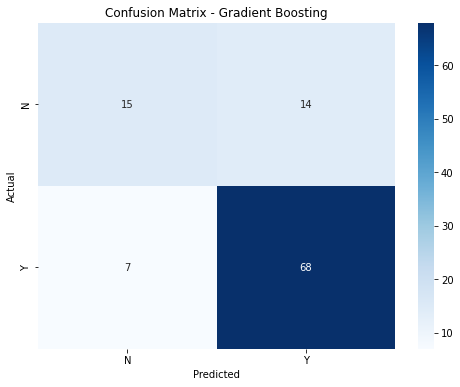

In [75]:
# Create a Gradient Boosting model
model = GradientBoostingClassifier()

# Define the parameter grid
gb_param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.1, 0.05, 0.01],
    "n_estimators": [100, 200, 300],
    "subsample": [0.8, 1.0],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Perform grid search using cross-validation
grid_search = GridSearchCV(model, param_grid=gb_param_grid, cv=kfold, scoring="accuracy", n_jobs=4)
grid_search.fit(X_train_scaled, y_train)

# Get the best model and its parameters
best_model_gb = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions using the best model
predictions_gb = best_model_gb.predict(X_test_scaled)

cm = confusion_matrix(y_test, predictions_gb)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'Y'], yticklabels=['N', 'Y'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Gradient Boosting')
plt.show()

In [76]:
print(best_model_gb)

GradientBoostingClassifier(max_depth=7, min_samples_split=5, n_estimators=200,
                           subsample=0.8)


In [77]:
# Compute precision, F1 score, and recall score
precision = precision_score(y_test, predictions_gb, pos_label='Y')
f1 = f1_score(y_test, predictions_gb, pos_label='Y')
recall = recall_score(y_test, predictions_gb, pos_label='Y')
acc = accuracy_score(y_test, predictions_gb)

# Print the scores
print("Precision: {:.2f}".format(precision))
print("Accuracy: {:.2f}".format(acc))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Precision: 0.83
Accuracy: 0.80
Recall: 0.91
F1 Score: 0.87


## Multiple Layer Perceptron

c:\Users\hp\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


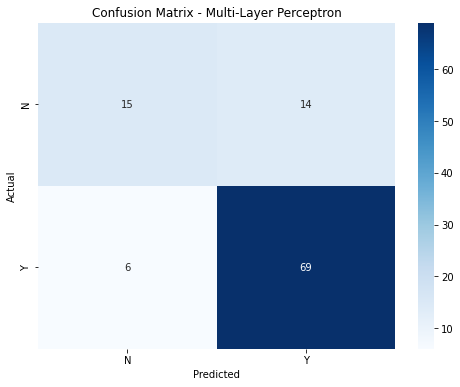

In [78]:
model = MLPClassifier()

# Define the parameter grid
mlp_param_grid = {
    "hidden_layer_sizes": [(100,), (50, 50), (50, 100)],
    "activation": ['relu', 'tanh'],
    "solver": ['adam', 'sgd'],
    "learning_rate": ['constant', 'adaptive'],
}

# Perform grid search using cross-validation
grid_search = GridSearchCV(model, param_grid=mlp_param_grid, cv=kfold, scoring="accuracy", n_jobs=4)
grid_search.fit(X_train_scaled, y_train)

# Get the best model and its parameters
best_model_mlp = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions using the best model
predictions_mlp = best_model_mlp.predict(X_test_scaled)

cm = confusion_matrix(y_test, predictions_mlp)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'Y'], yticklabels=['N', 'Y'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Multi-Layer Perceptron')
plt.show()

In [79]:
print(best_model_mlp)

MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 100))


In [80]:
# Compute precision, F1 score, and recall score
precision = precision_score(y_test, predictions_mlp, pos_label='Y')
f1 = f1_score(y_test, predictions_mlp, pos_label='Y')
recall = recall_score(y_test, predictions_mlp, pos_label='Y')
acc = accuracy_score(y_test, predictions_mlp)

# Print the scores
print("Precision: {:.2f}".format(precision))
print("Accuracy: {:.2f}".format(acc))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Precision: 0.83
Accuracy: 0.81
Recall: 0.92
F1 Score: 0.87


## KNN

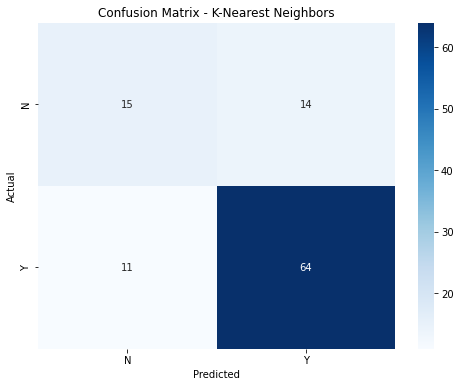

In [81]:
# Create a KNN model
model = KNeighborsClassifier()

# Define the parameter grid
knn_param_grid = {
    "n_neighbors": [2, 3, 4],
    "weights": ['uniform', 'distance'],
    "algorithm": ['auto', 'ball_tree', 'kd_tree', 'brute'],
    "p": [1, 2]
}

# Perform grid search using cross-validation
grid_search = GridSearchCV(model, param_grid=knn_param_grid, cv=kfold, scoring="accuracy", n_jobs=4)
grid_search.fit(X_train_scaled, y_train)

# Get the best model and its parameters
best_model_knn = grid_search.best_estimator_
best_params = grid_search.best_params_

# Make predictions using the best model
predictions_knn = best_model_knn.predict(X_test_scaled)

cm = confusion_matrix(y_test, predictions_knn)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'Y'], yticklabels=['N', 'Y'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - K-Nearest Neighbors')
plt.show()


In [82]:
print(best_model_knn)

KNeighborsClassifier(n_neighbors=4, p=1, weights='distance')


In [83]:
# Compute precision, F1 score, and recall score
precision = precision_score(y_test, predictions_knn, pos_label='Y')
f1 = f1_score(y_test, predictions_knn, pos_label='Y')
recall = recall_score(y_test, predictions_knn, pos_label='Y')
acc = accuracy_score(y_test, predictions_knn)

# Print the scores
print("Precision: {:.2f}".format(precision))
print("Accuracy: {:.2f}".format(acc))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Precision: 0.82
Accuracy: 0.76
Recall: 0.85
F1 Score: 0.84


## Correlations Between the Predictions of Different Classifiers

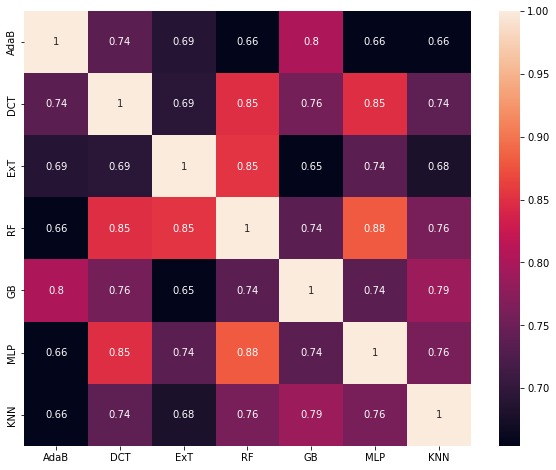

In [84]:
test_Survived_AdaB = pd.Series(predictions_adaboost, name="AdaB")
test_Survived_DCT = pd.Series(predictions_dt, name="DCT")
test_Survived_ExT = pd.Series(predictions_et, name="ExT")
test_Survived_RF = pd.Series(predictions_rf, name="RF")
test_Survived_GB = pd.Series(predictions_gb, name="GB")
test_Survived_MLP = pd.Series(predictions_mlp, name="MLP")
test_Survived_KNN = pd.Series(predictions_knn, name="KNN")

# Encode "Y" as 1 and "N" as 0
ensemble_results = pd.concat([test_Survived_AdaB.replace({"Y": 1, "N": 0}),
                              test_Survived_DCT.replace({"Y": 1, "N": 0}),
                              test_Survived_ExT.replace({"Y": 1, "N": 0}),
                              test_Survived_RF.replace({"Y": 1, "N": 0}),
                              test_Survived_GB.replace({"Y": 1, "N": 0}),
                              test_Survived_MLP.replace({"Y": 1, "N": 0}),
                              test_Survived_KNN.replace({"Y": 1, "N": 0})],
                             axis=1)

plt.figure(figsize=(10, 8))
g = sns.heatmap(ensemble_results.corr(), annot=True)
plt.show()


## Ensemble Modeling

In [85]:
from sklearn.ensemble import VotingClassifier

In [86]:
# Define the parameter grid for grid search
param_grid = {
    'AdaB__n_estimators': [50, 100, 200],
    'DCT__max_depth': [None, 3, 5],
    'ExT__n_estimators': [50, 100, 200],
    'RF__n_estimators': [50, 100, 200],
    'GB__n_estimators': [50, 100, 200],
    'MLP__hidden_layer_sizes': [(100,), (50, 50), (50, 100)],
    'KNN__n_neighbors': [3, 5, 7]
}

# Create the VotingClassifier
votingC = VotingClassifier(estimators=[
    ('AdaB', best_model_adaboost),
    ('DCT', best_model_dt),
    ('ExT', best_model_et),
    ('RF', best_model_rf),
    ('GB', best_model_gb),
    ('MLP', best_model_mlp),
    ('KNN', best_model_knn)
], voting='hard', n_jobs=4)

# Perform grid search using cross-validation
grid_search = GridSearchCV(votingC, param_grid=param_grid, cv=kfold, scoring="accuracy", n_jobs=4)
grid_search.fit(X_train_scaled, y_train)

# Get the best model and its parameters
best_model_voting = grid_search.best_estimator_
best_params = grid_search.best_params_

# Fit the best model on the training data
best_model_voting.fit(X_train_scaled, y_train)

VotingClassifier(estimators=[('AdaB',
                              AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                                 learning_rate=0.1,
                                                 n_estimators=100)),
                             ('DCT',
                              DecisionTreeClassifier(max_depth=3,
                                                     min_samples_leaf=4)),
                             ('ExT',
                              ExtraTreesClassifier(criterion='entropy',
                                                   max_features='sqrt',
                                                   min_samples_split=3)),
                             ('RF',
                              RandomForestClassifier(max_depth=10,
                                                     max_features='log2')),
                             ('GB',
                              GradientBoostingClassifier(max_depth=7,
      

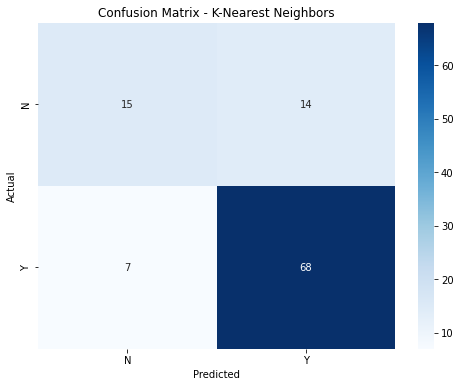

In [87]:
# Make predictions using the best model
predictions_votingC = best_model_voting.predict(X_test_scaled)

cm = confusion_matrix(y_test, predictions_votingC)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['N', 'Y'], yticklabels=['N', 'Y'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - K-Nearest Neighbors')
plt.show()

In [88]:
# Compute precision, F1 score, and recall score
precision = precision_score(y_test, predictions_votingC, pos_label='Y')
f1 = f1_score(y_test, predictions_votingC, pos_label='Y')
recall = recall_score(y_test, predictions_votingC, pos_label='Y')
acc = accuracy_score(y_test, predictions_votingC)

# Print the scores
print("Precision: {:.2f}".format(precision))
print("Accuracy: {:.2f}".format(acc))
print("Recall: {:.2f}".format(recall))
print("F1 Score: {:.2f}".format(f1))

Precision: 0.83
Accuracy: 0.80
Recall: 0.91
F1 Score: 0.87


## Submission

In [89]:
cleaned_test_encoded = ct.transform(cleaned_test)
cleaned_test_encoded_df = pd.DataFrame(cleaned_test_encoded, columns=column_names)


columns_to_log = ['remainder__ApplicantIncome', 'remainder__CoapplicantIncome', 
                  'remainder__LoanAmount', 'remainder__Loan_Amount_Term']


for col in columns_to_log:
    cleaned_test_encoded_df[col]  = np.log1p(cleaned_test_encoded_df[col])
    
cleaned_test_encoded_df_v2 = cleaned_test_encoded_df.drop(['one_hot__Gender_Female', 'one_hot__Married_No', 'one_hot__Education_Graduate', 'one_hot__Self_Employed_No'], axis=1)  

In [90]:
cleaned_test_encoded_df_v2 = cleaned_test_encoded_df_v2.values
cleaned_test_encoded_df_scaled = scaler.transform(cleaned_test_encoded_df_v2)

In [91]:

submission = pd.DataFrame({ 'Loan_ID': final_id,
                            'Loan_Status': best_model_voting.predict(cleaned_test_encoded_df_scaled) })


submission.to_csv("prediction/prediction_ensemble.csv", index=False)